# Trabajo Final - Algoritmos evolutivos I
Carrera de especialización en Inteligencia Artificial (CEIA)  
Facultad de Ingeniería - Universidad de Buenos Aires (FIUBA)  
##### Autor: Diego Araujo  


## Asignación óptima de móviles ante saltos de alarma mediante algoritmos genéticos

El despliegue óptimo de móviles de respuesta ante eventos simultáneos, por ejemplo en saltos de alarma en sistemas de seguridad, representa un desafío logístico de gran relevancia para empresas del rubro. Este trabajo se centra en una versión estática del problema, donde un conjunto de alarmas se activan de forma simultánea en una ciudad, y deben ser atendidas por una flota limitada de móviles que parten desde una misma base.
		
El objetivo es minimizar la distancia total recorrida por los móviles al atender las alarmas, contemplando además aspectos como el equilibrio en la carga de trabajo entre unidades y el orden de atención dentro de cada ruta. Para ello, se implementó una solución basada en algoritmos genéticos, una técnica inspirada en la evolución natural que ha demostrado ser efectiva en problemas de optimización combinatoria complejos.

#### 1. Librerías utilizadas

In [40]:
## 1.Librerías a utilizar

import random
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
import geopandas as gpd
import folium
from scipy.spatial.distance import euclidean
import pandas as pd
import requests
import time


#### 2. Parámetros globales generales 

Lo primero es establecer los parámetros principales que definen el problema de planificación y las condiciones bajo las cuales se ejecutará el algoritmo genético. Estos parámetros afectan tanto la simulación del entorno como el comportamiento del modelo evolutivo.

**Parámetros del problema**

- `N_ALARMAS`: Número total de eventos de alarma que deben ser atendidos por los móviles.
- `N_MOVILES`: Cantidad de móviles de respuesta disponibles para asignar a eventos.
- `VELOCIDAD_KMH`: Velocidad media de desplazamiento utilizada para convertir distancias en tiempos estimados de respuesta. Se fija en 45 km/h, acorde al límite máximo en ciudad.
- `BALANCEAR_CARGA`: Indicador booleano que activa una penalización si las rutas asignadas a los móviles están desbalanceadas en cantidad de puntos.
- `PENALIZACION_CARGA`: Factor de penalización aplicado a la función de aptitud cuando se desea equilibrar la carga entre móviles.

**Parámetros del algoritmo genético**

- `N_GENERACIONES`: Número de generaciones que se ejecutarán durante la evolución del algoritmo.
- `TAM_POBLACION`: Tamaño de la población de soluciones en cada generación.
- `TASA_MUTACION`: Proporción de individuos que serán afectados por mutaciones en cada generación, introduciendo diversidad genética.

In [41]:
N_ALARMAS = 40              # Número de alarmas a simular
N_MOVILES = 3               # Número de móviles disponibles
VELOCIDAD_KMH = 45          # Velocidad promedio para conversión tiempo (km/h) 
BALANCEAR_CARGA = True      # T|F para penalizar rutas desbalanceadas
PENALIZACION_CARGA = 1.0     

## Parámetros para la inicialización de los algoritmos genéticos

N_GENERACIONES = 1000
TAM_POBLACION=100 
TASA_MUTACION=0.2

#### 3. Simulación de coordenadas

Se realiza la generación aleatoria de los puntos geográficos que representan los saltos de alarma a atender. Estos puntos son ubicados dentro de un área geográfica simulada correspondiente a la ciudad de Montevideo.

> **Importante:** los puntos utilizados no corresponden a datos reales, sino que se tratan de datos completamente simulados, generados con el único propósito de evaluar el comportamiento del modelo. Dado que se trata de un problema sensible desde el punto de vista de la seguridad, se optó por emular una situación realista, sin comprometer información operativa o confidencial.

Para asegurar la validez espacial de los datos, se define un polígono que delimita la zona urbana y se generan coordenadas aleatorias que se validan dentro de ese cuadrante mediante operaciones geométricas. Solo se conservan los puntos que efectivamente caen dentro del área válida.

Además, se establece un punto fijo que representa la base de partida de los móviles de respuesta. Posteriormente, todos los puntos (base + alarmas) se visualizan en un mapa interactivo utilizando la librería `folium`, que permite visualizar la distribución geográfica de los eventos simulados.

In [ ]:
# Simulación de puntos

random.seed(19)

# Se hace un muestreo de puntos dentro de la ciudad
montevideo_coords = [(-56.35, -34.90), (-56.10, -34.90), (-56.10, -34.75), (-56.35, -34.75)]
montevideo_polygon = Polygon(montevideo_coords)

alarmas = []
while len(alarmas) < N_ALARMAS:
    lon = random.uniform(-56.35, -56.10)
    lat = random.uniform(-34.90, -34.75)
    punto = Point(lon, lat)

    if montevideo_polygon.contains(punto):
            alarmas.append(punto)

base_movil = Point(-56.20, -34.85)
all_coord = [base_movil] + alarmas
n_puntos = len(all_coord)


mapa_alarmas = folium.Map(location=[-34.85, -56.20], zoom_start=12)

# Marcadores de los puntos
for idx, punto in enumerate(alarmas, start=1):
    folium.Marker(
        location=[punto.y, punto.x],
        icon=folium.Icon(icon='house-flag', prefix='fa', color='darkred')
    ).add_to(mapa_alarmas)

mapa_alarmas

#### 4. Matriz de distancias

Una vez generados los puntos correspondientes a la base de móviles y a los eventos de alarma, es necesario calcular la distancia entre todos los pares posibles. Para eso, se construye una matriz que contiene las distancias euclidianas entre cada combinación de puntos.

Esta matriz es fundamental para el cálculo de la función de aptitud del algoritmo genético, ya que permite estimar rápidamente el costo de una ruta sin necesidad de recalcular distancias en cada iteración. Se asume un modelo simplificado donde las distancias entre puntos se calculan mediante la fórmula euclidiana clásica en coordenadas geográficas (x, y), sin considerar restricciones reales del entorno urbano como calles, tráfico o tiempos de ruta.

Aunque este enfoque no refleja la complejidad del mundo real, resulta útil para la etapa de simulación inicial, permitiendo evaluar el funcionamiento del modelo de optimización en condiciones controladas y reproducibles.

In [43]:
distancias = np.zeros((n_puntos, n_puntos))
for i in range(n_puntos):
    for j in range(n_puntos):
        distancias[i][j] = euclidean((all_coord[i].x, all_coord[i].y),
                                     (all_coord[j].x, all_coord[j].y))

#### 5. Funciones auxiliares

Se definen funciones clave que conforman la base operativa del algoritmo genético, para poder representar, evaluar y manipular soluciones de manera eficiente. Estas funciones fueron creadas para trabajar con una codificación basada en permutaciones de alarmas, donde cada cromosoma representa una secuencia de eventos a ser atendidos por un conjunto de móviles.

Las funciones incluidas son:

- **`dividir_ruta`**: divide un cromosoma en subrutas correspondientes a cada móvil, distribuyendo las alarmas de forma lo más equitativa posible.
- **`calcular_fitness`**: evalúa la calidad de una solución, considerando tanto la distancia total (aproximada) como el desbalance entre móviles, y permite convertirla en tiempo estimado de atención (también aproximado).
- **`crear_poblacion`**: genera una población inicial aleatoria de soluciones válidas para iniciar el proceso evolutivo.
- **`seleccion_torneo`**: implementa un mecanismo de selección basado en competencia entre pares aleatorios, favoreciendo la supervivencia de los mejores individuos.
- **`crossover_ox`**: aplica el operador de cruzamiento de tipo *Order Crossover*, preservando la validez de las permutaciones sin duplicar eventos.
- **`mutacion_swap`**: introduce variabilidad genética mediante el intercambio aleatorio de dos posiciones dentro de un cromosoma.

Estas funciones constituyen los bloques fundamentales para el funcionamiento del algoritmo genético.

In [44]:
def dividir_ruta(cromosoma, n_mobiles=N_MOVILES):
    cortes = np.linspace(0, len(cromosoma), n_mobiles + 1, dtype=int)
    rutas = [cromosoma[cortes[i]:cortes[i+1]] for i in range(n_mobiles)]
    return rutas

def calculo_fitness(cromosoma, distancias, 
                               balancear_carga=BALANCEAR_CARGA, 
                               penalizacion_carga=PENALIZACION_CARGA,
                               usar_tiempo=True,
                               velocidad_kmh=VELOCIDAD_KMH):
    rutas = dividir_ruta(cromosoma)
    totales = []
    for ruta in rutas:
        if len(ruta) == 0:
            totales.append(0)
            continue
        total = 0
        anterior = 0
        for punto in ruta:
            d = distancias[anterior][punto]
            total += d
            anterior = punto
        totales.append(total)
        
    distancia_total = sum(totales)
    if balancear_carga:
        desviacion = np.std(totales)
        distancia_total += penalizacion_carga * desviacion
    if usar_tiempo:
        # Este cálculo está basado en la conversión de grados a km, suponiendo que 1° ~ 111 kms
        distancia_total = (distancia_total * 111) / velocidad_kmh * 60
    return distancia_total

def crear_poblacion(tam_poblacion, n_alarmas):
    poblacion = []
    for _ in range(tam_poblacion):
        cromosoma = list(range(1, n_alarmas + 1))
        random.shuffle(cromosoma)
        poblacion.append(cromosoma)
    return poblacion

def seleccion_torneo(poblacion, fitnesses):
    i, j = random.sample(range(len(poblacion)), 2)
    return poblacion[i] if fitnesses[i] < fitnesses[j] else poblacion[j]

def crossover_ox(padre1, padre2):
    n = len(padre1)
    i, j = sorted(random.sample(range(n), 2))
    hijo = [None] * n
    hijo[i:j] = padre1[i:j]
    p2_idx = 0
    for k in range(n):
        if hijo[k] is None:
            while padre2[p2_idx] in hijo:
                p2_idx += 1
            hijo[k] = padre2[p2_idx]
    return hijo

def mutacion_swap(cromosoma):
    a, b = random.sample(range(len(cromosoma)), 2)
    cromosoma[a], cromosoma[b] = cromosoma[b], cromosoma[a]
    return cromosoma



#### 6. Algoritmo genético 

Esta sección implementa y ejecuta el algoritmo genético que permite encontrar una asignación eficiente de móviles a alarmas, minimizando la distancia (o tiempo) total de respuesta.

El proceso sigue un esquema evolutivo compuesto por:

- **Inicialización aleatoria de la población**: se generan soluciones válidas mediante permutaciones de los eventos a cubrir.
- **Evaluación de aptitud**: cada individuo es evaluado mediante una función de fitness que considera la distancia recorrida por cada móvil (pudiendo haciendo la conversión a tiempo), con penalizaciones (opcionales) por desbalance de carga.
- **Selección**: se aplica el *método de torneo* para elegir padres que participarán en la reproducción.
- **Cruza (crossover)**: se utiliza un operador de tipo *Order Crossover* que respeta el orden relativo y evita duplicaciones.
- **Mutación**: se introduce diversidad en la población mediante el intercambio aleatorio de dos eventos.
- **Reemplazo generacional completo**: cada nueva generación sustituye completamente a la anterior.
- **Registro de la mejor solución**: se guarda el mejor individuo hallado a lo largo del proceso, así como el historial de fitness por generación.

Este algoritmo permite explorar de forma eficiente el espacio de soluciones posibles, aproximando una asignación óptima que minimiza los recursos necesarios para cubrir todos los eventos desde una base común.

In [45]:
historial_fitness = []

def algoritmo_genetico(N_GENERACIONES = N_GENERACIONES, 
                       TAM_POBLACION = TAM_POBLACION,
                        TASA_MUTACION = TASA_MUTACION):
    poblacion = crear_poblacion(TAM_POBLACION, N_ALARMAS)
    #print(poblacion)
    mejor_solucion = None
    mejor_fitness = float('inf') # Para poder minimizar, se arranca con un valor "grande"
    for gen in range(N_GENERACIONES):
        fitnesses = [calculo_fitness(ind, distancias) for ind in poblacion]
        historial_fitness.append(min(fitnesses))
        for ind, fit in zip(poblacion, fitnesses):
            if fit < mejor_fitness:
                mejor_fitness = fit
                mejor_solucion = ind[:]
        nueva_poblacion = []
        while len(nueva_poblacion) < TAM_POBLACION:
            padre1 = seleccion_torneo(poblacion, fitnesses)
            padre2 = seleccion_torneo(poblacion, fitnesses)
            hijo = crossover_ox(padre1, padre2)
            if random.random() < TASA_MUTACION:
                hijo = mutacion_swap(hijo)
            nueva_poblacion.append(hijo)
        poblacion = nueva_poblacion
        if gen % 20 == 0:
            print(f"Generación {gen} \t  ---- \t Mejor fitness: {mejor_fitness:.2f}")
    return mejor_solucion, mejor_fitness

mejor_solucion, mejor_fitness = algoritmo_genetico()



Generación 0 	  ---- 	 Mejor fitness: 516.10
Generación 20 	  ---- 	 Mejor fitness: 408.34
Generación 40 	  ---- 	 Mejor fitness: 386.23
Generación 60 	  ---- 	 Mejor fitness: 363.71
Generación 80 	  ---- 	 Mejor fitness: 363.71
Generación 100 	  ---- 	 Mejor fitness: 363.71
Generación 120 	  ---- 	 Mejor fitness: 360.81
Generación 140 	  ---- 	 Mejor fitness: 360.81
Generación 160 	  ---- 	 Mejor fitness: 305.60
Generación 180 	  ---- 	 Mejor fitness: 287.15
Generación 200 	  ---- 	 Mejor fitness: 264.42
Generación 220 	  ---- 	 Mejor fitness: 235.20
Generación 240 	  ---- 	 Mejor fitness: 217.50
Generación 260 	  ---- 	 Mejor fitness: 206.72
Generación 280 	  ---- 	 Mejor fitness: 196.47
Generación 300 	  ---- 	 Mejor fitness: 196.47
Generación 320 	  ---- 	 Mejor fitness: 196.47
Generación 340 	  ---- 	 Mejor fitness: 196.47
Generación 360 	  ---- 	 Mejor fitness: 189.80
Generación 380 	  ---- 	 Mejor fitness: 188.33
Generación 400 	  ---- 	 Mejor fitness: 188.33
Generación 420 	  -

#### 7. Visualización de rutas

Este bloque representa gráficamente la mejor solución obtenida por el algoritmo genético sobre un mapa interactivo. El objetivo es facilitar la interpretación espacial de las rutas asignadas a los móviles y validar que la distribución sea eficiente y coherente.

En el mapa se puede observar:

- Un marcador en la base de salida de los móviles (identificado con un ícono de vehículo).
- Círculos de colores que indican los puntos de alarma asignados a cada móvil.
- Números que indican el orden de visita dentro de cada ruta.
- Líneas que conectan los puntos de cada ruta, desde la base hasta el último evento asignado.

Cada ruta utiliza un color diferente para distinguir visualmente las asignaciones entre móviles y permite verificar si las rutas son compactas, si hay solapamientos innecesarios o si algún móvil quedó sin carga asignada.

In [46]:
colores = ['blue', 'green', 'red', 'purple', 'black']
mapa_solucion = folium.Map(location=[-34.85, -56.20], zoom_start=12)
folium.Marker(location=[base_movil.y, base_movil.x], popup='Base', icon=folium.Icon(icon='car', prefix='fa', color='cadetblue')).add_to(mapa_solucion)

rutas = dividir_ruta(mejor_solucion)
for i, ruta in enumerate(rutas):
    if not ruta:
        continue
    coords = [(base_movil.y, base_movil.x)]
    for orden, idx in enumerate(ruta, start=1):
        punto = all_coord[idx]
        coords.append((punto.y, punto.x))
        folium.Marker(
            location=[punto.y, punto.x],
            icon=folium.DivIcon(
                html=f'''
                    <div style="
                        font-size: 12px;
                        color: {colores[i % len(colores)]};
                        transform: translate(0px, -12px);
                        text-align: center;
                    ">
                        {orden}
                    </div>
                '''
            )
        ).add_to(mapa_solucion)
        folium.CircleMarker(
            location=[punto.y, punto.x],
            radius=3,
            color=colores[i % len(colores)],
            fill=True,
            fill_opacity=0.7
        ).add_to(mapa_solucion)
    folium.PolyLine(coords, color=colores[i % len(colores)], weight=3, opacity=0.8).add_to(mapa_solucion)

    
mapa_solucion


#### 8. Evolución del fitness



Este gráfico permite observar cómo evoluciona la calidad de las soluciones generadas por el algoritmo genético a lo largo de las generaciones. El eje X indica el número de generación, mientras que el eje Y representa el valor mínimo de fitness observado en esa generación. En este contexto, el fitness corresponde al tiempo total estimado en minutos que los móviles necesitan para atender todas las alarmas asignadas.

El análisis de la curva muestra una fase inicial con mejoras rápidas (exploración del espacio de soluciones), seguida por una zona de estabilización donde el algoritmo refina soluciones cada vez más cercanas al óptimo. A partir de cierto punto (alrededor de la generación 400), las mejoras se vuelven marginales, lo que parece indicar cierta convergencia del proceso evolutivo.

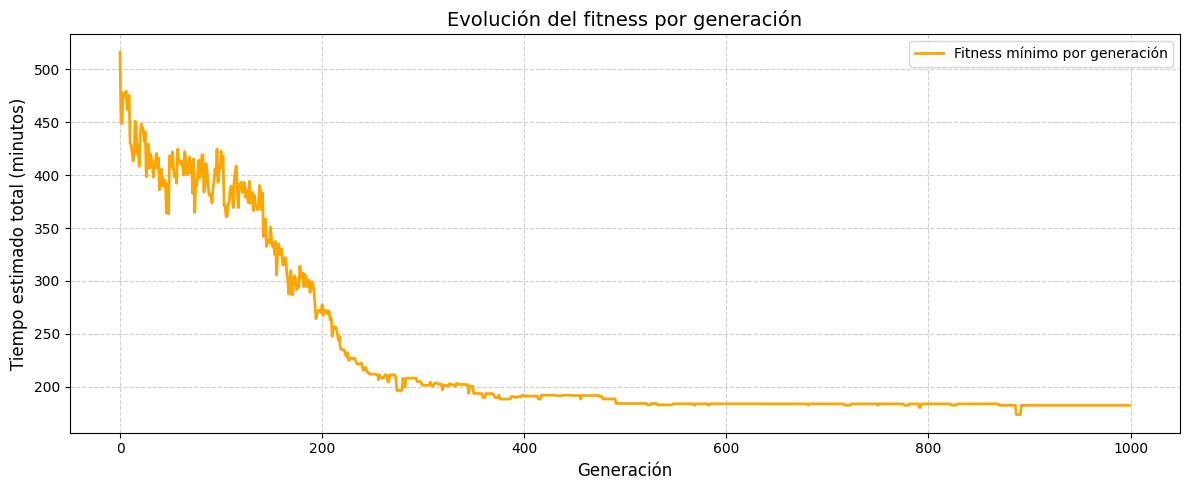

In [47]:
plt.figure(figsize=(12, 5))
plt.plot(historial_fitness, label='Fitness mínimo por generación', color='orange', linewidth=2)
plt.title('Evolución del fitness por generación', fontsize=14)
plt.xlabel('Generación', fontsize=12)
plt.ylabel('Tiempo estimado total (minutos)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='upper right', fontsize=10)
plt.tight_layout()
plt.show()


#### 9. Comparación con asignación aleatoria

Es necesario comparar el desempeño de la mejor solución obtenida mediante el algoritmo genético con algún otro tipo de solución (por ejemplo una generada aleatoriamente). El objetivo es cuantificar la mejora alcanzada gracias al proceso evolutivo.

Para poder comparar esto, se realizan los siguientes pasos:

- Se construye un cromosoma completamente aleatorio que representa una asignación no optimizada de las alarmas.
- Se evalúa su valor de fitness utilizando la misma función empleada en el algoritmo.
- Luego se compara contra el fitness de la mejor solución optimizada.

In [48]:

random_solucion = list(range(1, N_ALARMAS + 1))
random.shuffle(random_solucion)
fitness_random = calculo_fitness(random_solucion, distancias)
print(f"Fitness de una solución aleatoria: {fitness_random:.2f}")
print(f"Fitness de la mejor solución optimizada: {mejor_fitness:.2f}")


Fitness de una solución aleatoria: 617.94
Fitness de la mejor solución optimizada: 173.64


Los resultados muestran una diferencia muy significativa:

- **Solución aleatoria:** 617.94 minutos estimados de atención total.
- **Mejor solución optimizada:** 173.64 minutos.

Esto representa una mejora superior al **70%** en eficiencia operativa. El resultado evidencia que una asignación arbitraria puede ser extremadamente ineficiente, generando recorridos largos y desbalance entre móviles. En contraste, el algoritmo genético encuentra una estructura de rutas mucho más eficiente, logrando una distribución espacial adecuada y menor tiempo de atención global.


#### 10. Tiempos por móvil (mejor solución)

Este gráfico permite analizar cómo se reparte la carga operativa entre los móviles en la mejor solución encontrada por el algoritmo genético. Se calcula la distancia euclidiana total recorrida por cada móvil desde la base hasta las alarmas asignadas y luego se hace la conversión (aproximada) a minutos.

El objetivo de esta visualización es evaluar si la asignación lograda por el modelo no solo es eficiente en términos globales, sino también equilibrada en términos de carga entre los vehículos. Esto resulta relevante en contextos operativos donde se busca evitar sobrecargar a una unidad mientras otras quedan subutilizadas.


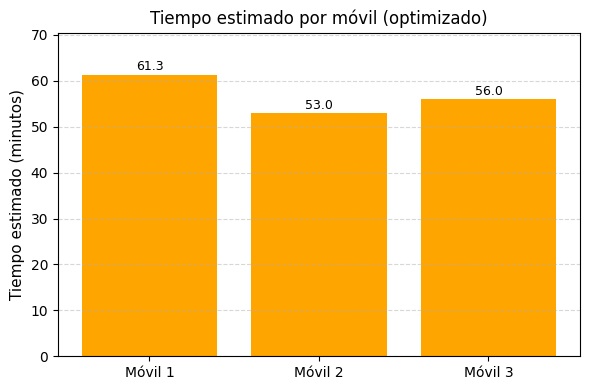

In [49]:
rutas_opt = dividir_ruta(mejor_solucion)
distancias_por_movil = []

for ruta in rutas_opt:
    total = 0
    anterior = 0
    for idx in ruta:
        total += distancias[anterior][idx]
        anterior = idx
    distancias_por_movil.append(total)

# Conversión de distancia euclidiana a tiempo estimado (minutos)
distancias_minutos = [
    (d * 111) / VELOCIDAD_KMH * 60 for d in distancias_por_movil
]

# Gráfico
plt.figure(figsize=(6, 4))
barras = plt.bar([f'Móvil {i+1}' for i in range(len(rutas_opt))], distancias_minutos, color='orange')
plt.title('Tiempo estimado por móvil (optimizado)', fontsize=12)
plt.ylabel('Tiempo estimado (minutos)', fontsize=11)
plt.ylim(0, max(distancias_minutos) * 1.15)  # margen superior
plt.grid(axis='y', linestyle='--', alpha=0.5)

#Etiquetas de tiempo sobre las barras
for bar in barras:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1, f'{height:.1f}', ha='center', fontsize=9)

plt.tight_layout()
plt.show()

Los tiempos fueron calculados a partir de la distancia euclidiana total recorrida por cada móvil, convertida a minutos usando una velocidad constante de 45 km/h.

Aunque la distribución no es perfectamente equitativa, los tiempos están en un rango bastante acotado (entre 53 y 61 minutos), lo que sugiere que el algoritmo logró mantener una distribución razonable sin comprometer la eficiencia global. De hecho, y desde una perspectiva operativa, que ningún móvil supere la hora de recorrido sugiere que la solución es viable y eficiente, especialmente si se asume que este recorrido se realiza en una única salida o ronda.

La penalización activada (BALANCEAR_CARGA = True) contribuyó a evitar escenarios en los que un solo móvil tuviera que realizar un recorrido desproporcionado respecto a los demás.


#### 11. Optimización de hiperparámetros mediante Optuna

Se aplica una estrategia de búsqueda automática para identificar combinaciones óptimas de hiperparámetros en el algoritmo genético. Utiliza la biblioteca [Optuna](https://optuna.org/), basada en técnicas de optimización bayesiana, que permite explorar el espacio de configuraciones sin necesidad de definir manualmente cada combinación.

Durante cada prueba, Optuna evalúa parámetros clave como:

- Cantidad de generaciones (`N_GENERACIONES`)
- Tamaño de la población (`TAM_POBLACION`)
- Tasa de mutación (`TASA_MUTACION`)
- Penalización por desbalance de carga (`PENALIZACION_CARGA`)
- Velocidad de los móviles (`VELOCIDAD_KMH`)

Cada conjunto de valores se prueba ejecutando el algoritmo genético, y se mide su desempeño mediante el valor de fitness alcanzado. El proceso se repite múltiples veces (`n_trials`), con el objetivo de minimizar el valor final de fitness, con el fin de encontrar una configuración adecuada del modelo, mejorando la eficiencia y robustez de los resultados obtenidos frente a métodos ajustados de forma manual.


In [50]:
# Si no está instalado optuna en colab, habría que instalarlo
try:
    import optuna
except ImportError:
    !pip install optuna
    import optuna

In [51]:
import optuna

def objective(trial):
    # Sugerencia de hiperparámetros
    n_generaciones = trial.suggest_int('N_GENERACIONES', 50, 2000)
    tam_poblacion = trial.suggest_int('TAM_POBLACION', 20, 150)
    tasa_mutacion = trial.suggest_float('TASA_MUTACION', 0.05, 0.5)
    penalizacion_carga = trial.suggest_float('PENALIZACION_CARGA', 0.0, 5.0)
    velocidad_kmh = trial.suggest_int('VELOCIDAD_KMH', 30, 50)

    # Se redefine la función GA local con estos hiperparámetros
    poblacion = crear_poblacion(tam_poblacion, N_ALARMAS)
    mejor_fitness = float('inf')

    for gen in range(n_generaciones):
        fitnesses = [calculo_fitness(ind, distancias,
                                                balancear_carga=True,
                                                penalizacion_carga=penalizacion_carga,
                                                usar_tiempo=True,
                                                velocidad_kmh=velocidad_kmh)
                     for ind in poblacion]

        nueva_poblacion = []
        while len(nueva_poblacion) < tam_poblacion:
            padre1 = seleccion_torneo(poblacion, fitnesses)
            padre2 = seleccion_torneo(poblacion, fitnesses)
            hijo = crossover_ox(padre1, padre2)
            if random.random() < tasa_mutacion:
                hijo = mutacion_swap(hijo)
            nueva_poblacion.append(hijo)

        poblacion = nueva_poblacion
        mejor_fitness = min(mejor_fitness, min(fitnesses))

    return mejor_fitness

# Optimización
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Resultados
print("Mejores hiperparámetros encontrados:")
print(study.best_params)
print(f"Mejor fitness alcanzado: {study.best_value:.2f}")


[I 2025-06-12 21:51:27,409] A new study created in memory with name: no-name-57cb81c4-5bd8-4743-a658-813116bdd9bd
[I 2025-06-12 21:51:35,844] Trial 0 finished with value: 169.97214950985207 and parameters: {'N_GENERACIONES': 1637, 'TAM_POBLACION': 80, 'TASA_MUTACION': 0.17340721840969253, 'PENALIZACION_CARGA': 2.340800284673273, 'VELOCIDAD_KMH': 49}. Best is trial 0 with value: 169.97214950985207.
[I 2025-06-12 21:51:37,498] Trial 1 finished with value: 358.13723323707063 and parameters: {'N_GENERACIONES': 702, 'TAM_POBLACION': 37, 'TASA_MUTACION': 0.08886803057956902, 'PENALIZACION_CARGA': 2.741393185148025, 'VELOCIDAD_KMH': 32}. Best is trial 0 with value: 169.97214950985207.
[I 2025-06-12 21:51:44,357] Trial 2 finished with value: 327.5324067790472 and parameters: {'N_GENERACIONES': 948, 'TAM_POBLACION': 113, 'TASA_MUTACION': 0.48450821345730505, 'PENALIZACION_CARGA': 0.879579077900785, 'VELOCIDAD_KMH': 43}. Best is trial 0 with value: 169.97214950985207.
[I 2025-06-12 21:51:50,947]

Mejores hiperparámetros encontrados:
{'N_GENERACIONES': 1413, 'TAM_POBLACION': 144, 'TASA_MUTACION': 0.22753859781067404, 'PENALIZACION_CARGA': 0.010408477211803525, 'VELOCIDAD_KMH': 50}
Mejor fitness alcanzado: 148.42


#### 12. Importancia de los hiperparámetros

Se analiza el impacto relativo de cada hiperparámetro sobre el valor final de fitness, mediante la funcionalidad `get_param_importances` de la biblioteca [Optuna](https://optuna.org/).

La estimación se basa en el resultado de los distintos `trials` realizados durante la optimización. Para cada hiperparámetro, Optuna calcula cuánto contribuye a la variabilidad del resultado, asumiendo todos los demás fijos. Esta técnica resulta útil para identificar qué parámetros influyen más en la calidad de la solución y cuáles tienen menor efecto.

Los valores se interpretan como proporciones del impacto total que los hiperparámetros tienen sobre la métrica optimizada. A mayor valor, mayor influencia sobre el rendimiento del algoritmo genético.

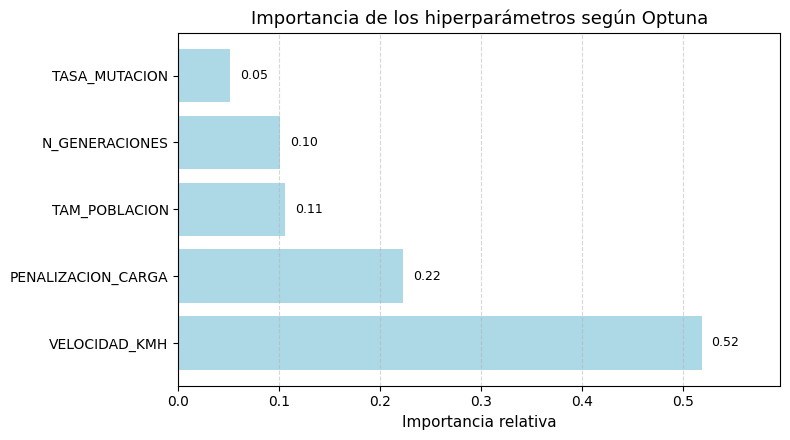

In [74]:
from optuna.importance import get_param_importances

# Importancia de cada hiperparámetro
importancias = get_param_importances(study)
importancias = dict(sorted(importancias.items(), key=lambda x: x[1], reverse=True))

plt.figure(figsize=(8, 4.5))
barras = plt.barh(list(importancias.keys()), list(importancias.values()), color='lightblue')
plt.xlabel("Importancia relativa", fontsize=11)
plt.title("Importancia de los hiperparámetros según Optuna", fontsize=13)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.xlim(0, max(importancias.values()) * 1.15)

# Valores numéricos a la derecha de cada barra
for i, (param, val) in enumerate(importancias.items()):
    plt.text(val + 0.01, i, f"{val:.2f}", va='center', fontsize=9)

plt.tight_layout()
plt.show()

Se pueden observar algunos puntos:
- El ajuste de penalización por carga y la velocidad resultan prioritarias para mejorar el rendimiento del modelo.

- Parámetros como `TASA_MUTACION` y `N_GENERACIONES`, si bien son importantes desde lo computacional, tienen menor impacto marginal sobre el fitness final.

#### 13. Gráfico de convergencia del algoritmo genético en Optuna

Este gráfico muestra la evolución del valor mínimo de fitness obtenido en cada una de las ejecuciones realizadas por Optuna. Cada trial representa una corrida independiente del algoritmo genético bajo una configuración distinta de hiperparámetros.

El análisis de convergencia permite observar:

- Qué tan variable fue el desempeño del algoritmo entre diferentes configuraciones.
- Cuántos trials lograron superar un determinado umbral de calidad.
- Cuál fue la estabilidad general del proceso de optimización.

Una tendencia decreciente o la aparición de valores bajos frecuentes en la parte final del gráfico puede interpretarse como señal de que Optuna encontró regiones prometedoras en el espacio de búsqueda.

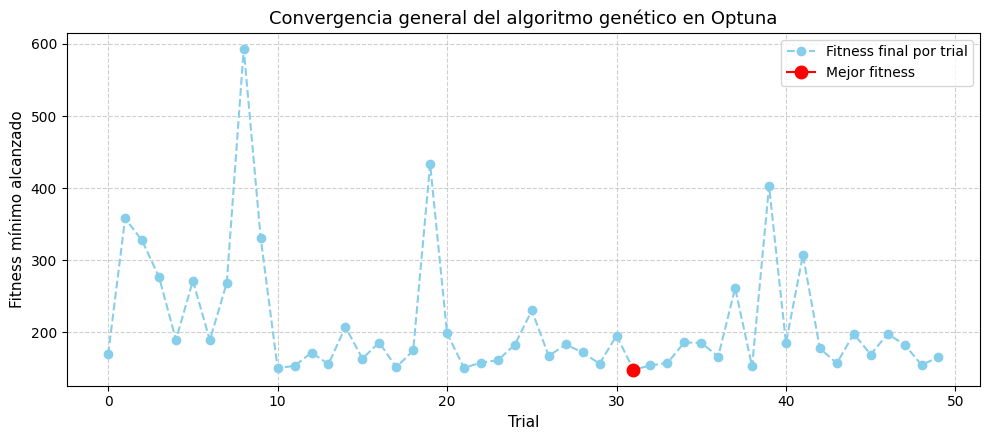

In [76]:

## 14. Gráfico de convergencia del algoritmo genético en Optuna

# Valores de fitness válidos
valores = [t.value for t in study.trials if t.state.name == 'COMPLETE']

# Mínimo valor
min_valor = min(valores)
min_idx = valores.index(min_valor)

plt.figure(figsize=(10, 4.5))
plt.plot(valores, marker='o', linestyle='--', color='skyblue', label='Fitness final por trial')

plt.plot(min_idx, min_valor, marker='o', color='red', markersize=9, label='Mejor fitness')

plt.title('Convergencia general del algoritmo genético en Optuna', fontsize=13)
plt.xlabel('Trial', fontsize=11)
plt.ylabel('Fitness mínimo alcanzado', fontsize=11)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

En el gráfico se puede observar que:

- Se presenta una **alta variabilidad inicial**.
    - Hay una fuerte dispersión en los valores de fitness en los primeros 20 trials.
    - Algunos trials alcanzan valores muy elevados (por encima de 400), lo que indica que ciertas configuraciones de parámetros son ineficientes o inestables.
- Hay una mejora a partir del trial 25 (la mayoría de los valores convergen a un rango entre 150 y 200), por lo que parece que Optuna logró enfocar la búsqueda en regiones prometedoras del espacio de hiperparámetros.
- El punto rojo marca el mínimo global, ubicado alrededor del trial 32.

#### 14. Ejecución del modelo con hiperparámetros óptimos de Optuna

Se ejecuta nuevamente el algoritmo genético, utilizando los mejores hiperparámetros seleccionados automáticamente por Optuna durante el proceso de optimización.

Se recuperan los valores óptimos para:
- Número de generaciones (`N_GENERACIONES`)
- Tamaño de la población (`TAM_POBLACION`)
- Tasa de mutación (`TASA_MUTACION`)

Con estos parámetros, se vuelve a correr el modelo completo para obtener una nueva solución optimizada y evaluar si efectivamente se alcanza un fitness inferior al obtenido con configuraciones previas. Esta validación permite comprobar que el proceso de optimización no solo exploró correctamente el espacio de búsqueda, sino que logró mejorar los resultados del modelo original.

Finalmente, la solución generada se divide en rutas individuales por móvil para su posterior visualización y análisis.

Mejores parámetros encontrados por Optuna:
{'N_GENERACIONES': 1413, 'TAM_POBLACION': 144, 'TASA_MUTACION': 0.22753859781067404, 'PENALIZACION_CARGA': 0.010408477211803525, 'VELOCIDAD_KMH': 50}
Generación 0 	  ---- 	 Mejor fitness: 498.87
Generación 20 	  ---- 	 Mejor fitness: 401.09
Generación 40 	  ---- 	 Mejor fitness: 376.67
Generación 60 	  ---- 	 Mejor fitness: 374.74
Generación 80 	  ---- 	 Mejor fitness: 374.74
Generación 100 	  ---- 	 Mejor fitness: 374.74
Generación 120 	  ---- 	 Mejor fitness: 374.74
Generación 140 	  ---- 	 Mejor fitness: 358.39
Generación 160 	  ---- 	 Mejor fitness: 358.39
Generación 180 	  ---- 	 Mejor fitness: 358.39
Generación 200 	  ---- 	 Mejor fitness: 358.39
Generación 220 	  ---- 	 Mejor fitness: 358.39
Generación 240 	  ---- 	 Mejor fitness: 358.39
Generación 260 	  ---- 	 Mejor fitness: 353.47
Generación 280 	  ---- 	 Mejor fitness: 353.47
Generación 300 	  ---- 	 Mejor fitness: 341.61
Generación 320 	  ---- 	 Mejor fitness: 337.22
Generación 340

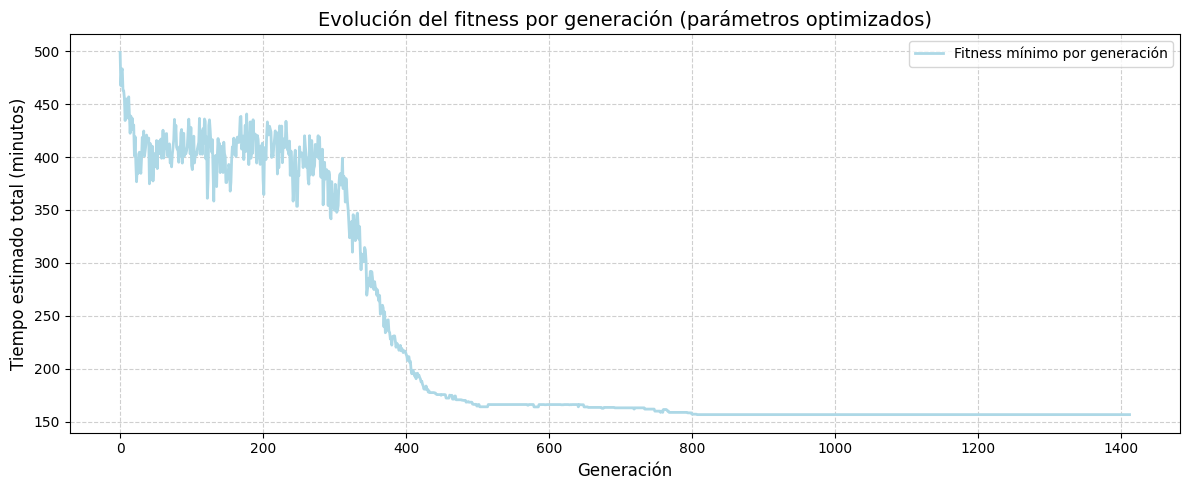

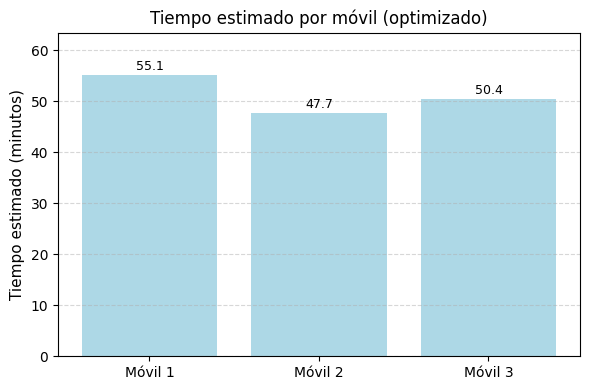

In [77]:
# Se usan los mejores hiperparámetros encontrados por Optuna
params_optimos = study.best_params
print("Mejores parámetros encontrados por Optuna:")
print(params_optimos)

random.seed(40)

VELOCIDAD_KMH = params_optimos['VELOCIDAD_KMH']   
PENALIZACION_CARGA = params_optimos['PENALIZACION_CARGA']     

historial_fitness = []

# Se ejecuta nuevamente el algoritmo genético con esos valores
mejor_solucion_opt, mejor_fitness_opt = algoritmo_genetico(
    N_GENERACIONES=params_optimos['N_GENERACIONES'],
    TAM_POBLACION=params_optimos['TAM_POBLACION'],
    TASA_MUTACION=params_optimos['TASA_MUTACION']
)

# Visualización del fitness final
print(f"Fitness obtenido con parámetros óptimos: {mejor_fitness_opt:.2f}")

# Guardar rutas optimizadas
rutas = dividir_ruta(mejor_solucion_opt)
print(rutas)


# Gráfico de convergencia con parámetros optimizados
plt.figure(figsize=(12, 5))
plt.plot(historial_fitness, label='Fitness mínimo por generación', color='lightblue', linewidth=2)
plt.title('Evolución del fitness por generación (parámetros optimizados)', fontsize=14)
plt.xlabel('Generación', fontsize=12)
plt.ylabel('Tiempo estimado total (minutos)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='upper right', fontsize=10)
plt.tight_layout()
plt.show()

# Gráfico tiempos optimizados
distancias_por_movil = []

for ruta in rutas_opt:
    total = 0
    anterior = 0
    for idx in ruta:
        total += distancias[anterior][idx]
        anterior = idx
    distancias_por_movil.append(total)

# Conversión de distancia euclidiana a tiempo estimado (minutos)
distancias_minutos = [
    (d * 111) / VELOCIDAD_KMH * 60 for d in distancias_por_movil
]

# Gráfico
plt.figure(figsize=(6, 4))
barras = plt.bar([f'Móvil {i+1}' for i in range(len(rutas_opt))], distancias_minutos, color='lightblue')
plt.title('Tiempo estimado por móvil (optimizado)', fontsize=12)
plt.ylabel('Tiempo estimado (minutos)', fontsize=11)
plt.ylim(0, max(distancias_minutos) * 1.15)  # margen superior
plt.grid(axis='y', linestyle='--', alpha=0.5)

#Etiquetas de tiempo sobre las barras
for bar in barras:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1, f'{height:.1f}', ha='center', fontsize=9)

plt.tight_layout()
plt.show()


El valor de 156.62 minutos es muy bajo en comparación con:

- El fitness de una solución aleatoria, que rondaba los 618 minutos.
- El mejor fitness alcanzado sin optimización de hiperparámetros, que estaba entre 170–180 minutos, según lo mostrado en gráficos anteriores.

Esto implica una mejora sustancial adicional gracias a la optimización de parámetros.

Este resultado confirma que Optuna fue capaz de encontrar una configuración más eficiente que la usada previamente, incluso cuando el algoritmo ya era competitivo. Las nuevas rutas se pueden ver a continuación.

In [72]:
colores = ['blue', 'green', 'red', 'purple', 'black']
mapa_solucion_opt = folium.Map(location=[-34.85, -56.20], zoom_start=12)
folium.Marker(location=[base_movil.y, base_movil.x], popup='Base', icon=folium.Icon(icon='car', prefix='fa', color='cadetblue')).add_to(mapa_solucion_opt)

rutas = dividir_ruta(mejor_solucion_opt)
for i, ruta in enumerate(rutas):
    if not ruta:
        continue
    coords = [(base_movil.y, base_movil.x)]
    for orden, idx in enumerate(ruta, start=1):
        punto = all_coord[idx]
        coords.append((punto.y, punto.x))
        folium.Marker(
            location=[punto.y, punto.x],
            icon=folium.DivIcon(
                html=f'''
                    <div style="
                        font-size: 12px;
                        color: {colores[i % len(colores)]};
                        transform: translate(0px, -12px);
                        text-align: center;
                    ">
                        {orden}
                    </div>
                '''
            )
        ).add_to(mapa_solucion_opt)
        folium.CircleMarker(
            location=[punto.y, punto.x],
            radius=3,
            color=colores[i % len(colores)],
            fill=True,
            fill_opacity=0.7
        ).add_to(mapa_solucion)
    folium.PolyLine(coords, color=colores[i % len(colores)], weight=3, opacity=0.8).add_to(mapa_solucion_opt)

    
mapa_solucion_opt